<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simulation-attempt-round-1" data-toc-modified-id="Simulation-attempt-round-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulation attempt round 1</a></span></li><li><span><a href="#Simulation-attempt-round-3" data-toc-modified-id="Simulation-attempt-round-3-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulation attempt round 3</a></span></li><li><span><a href="#Simulation-attempt-4" data-toc-modified-id="Simulation-attempt-4-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulation attempt 4</a></span></li><li><span><a href="#Create-household-matched-simulations" data-toc-modified-id="Create-household-matched-simulations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create household matched simulations</a></span></li></ul></div>

In [1]:
import biom
from biom.util import biom_open
import numpy as np
import pandas as pd
import arviz as az
from util import extract_differentials, ranking, btest, read_kegg_dict
import dask
from dask.distributed import Client
from arviz.utils import Dask
%matplotlib inline

# Simulation attempt round 1

Using the regenerated data from the differential abundance models.

In [3]:
kang_directory = '../sfari/data/sra/Kang2017'
posterior_file = f'{kang_directory}/week0_ogu/differentials-v8.nc'
posterior = az.from_netcdf(posterior_file)

In [4]:
posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [5]:
med_table = posterior['posterior_predictive']['y_predict'].loc[dict(chain=0, draw=0)]
med_table = med_table.to_dataframe()['y_predict']
med_table = pd.pivot(data=med_table.reset_index(), index='features', columns='samples').round()
med_table = med_table.astype(np.int64)

with biom_open('../sfari/data/sra/Combined/simulated.biom', 'w') as f:
    _, samples = zip(*med_table.columns)
    t = biom.Table(med_table.values, med_table.index, list(samples))
    t.to_hdf5(f, 'simulated')

In [6]:
med_table.sum(axis=1)

features
1000569       1456
1002367      75190
1006000       1620
1007096      46805
1008459         57
            ...   
997894      408891
999386          49
999411         224
999413       30389
999419     1044673
Length: 878, dtype: int64

# Simulation attempt round 3

Using the regenerated data from the differential abundance models to 
yield the parameters to simulate counts using our custom simulation code.

In [7]:
from q2_matchmaker._stan import _case_control_negative_binomial_sim, negative_binomial_rvs

In [8]:
params = posterior.mean(dim=['chain', 'draw'])
diff = params['posterior']['diff'].to_dataframe()
disp = params['posterior']['disp'].to_dataframe()
batch_mu = params['posterior']['batch_mu'].to_dataframe()
batch_disp = params['posterior']['batch_disp'].to_dataframe()
control_mu = params['posterior']['control_mu'].to_dataframe()
control_sigma = params['posterior']['control_sigma'].to_dataframe()

In [9]:
disp = pd.pivot(data=disp.reset_index(), index='features', columns='disp_dim_0')
batch_mu = pd.pivot(data=batch_mu.reset_index(), index='features', columns='batch_mu_dim_0')
batch_disp = pd.pivot(data=batch_disp.reset_index(), index='features', columns='batch_disp_dim_0')

In [10]:
params['posterior']

<xarray.Dataset>
Dimensions:           (batch_disp_dim_0: 8, batch_mu_dim_0: 8, control_dim_0: 377, disp_dim_0: 2, features: 878, lam_dim_0: 754, phi_dim_0: 754, samples: 754)
Coordinates:
  * disp_dim_0        (disp_dim_0) int64 0 1
  * batch_mu_dim_0    (batch_mu_dim_0) int64 0 1 2 3 4 5 6 7
  * batch_disp_dim_0  (batch_disp_dim_0) int64 0 1 2 3 4 5 6 7
  * control_dim_0     (control_dim_0) int64 0 1 2 3 4 5 ... 372 373 374 375 376
  * lam_dim_0         (lam_dim_0) int64 0 1 2 3 4 5 ... 748 749 750 751 752 753
  * phi_dim_0         (phi_dim_0) int64 0 1 2 3 4 5 ... 748 749 750 751 752 753
  * features          (features) object '1000569' '1002367' ... '999419'
  * samples           (samples) object 'SRR9666876' 'P19.stool' ... 'SRR9666788'
Data variables:
    diff              (features) float64 0.9538 -1.7 -1.842 ... -0.1186 -0.3837
    disp              (features, disp_dim_0) float64 0.1002 0.1005 ... 0.1033
    batch_mu          (features, batch_mu_dim_0) float64 -2.364 -2.85 ... 0.7904
    batch_disp        (features, batch_disp_dim_0) float64 8.096 2.603 ... 5.95
    control_mu        (features) float64 -15.02 -8.805 -14.53 ... -8.39 -5.284
    control_sigma     (features) float64 0.6214 1.2 0.7843 ... 0.3272 0.2886

In [11]:
n = 754
b = 8
d = 878
table, md, new_diff = _case_control_negative_binomial_sim(
    n, b, d, depth=10000, state=0,
    params=dict(
        diff=diff.values,
        disp=disp.values.T,
        batch_mu=batch_mu.values.T,
        batch_disp=batch_disp.values.T,
        control_mu=control_mu.values.ravel(),
        control_sigma=control_sigma.values.ravel()
    )
)

In [12]:
with biom_open('../sfari/data/sra/Combined/simulated3.biom', 'w') as f:
    #t = biom.Table(table.values.T, posterior['posterior']['features'], 
    #               posterior['posterior']['samples'])
    t = biom.Table(table.values.T, posterior['posterior']['features'], table.index)
    t.to_hdf5(f, 'simulated')

In [13]:
md.to_csv('../sfari/data/sra/Combined/simulated3_metadata.txt', sep='\t')

# Simulation attempt 4

Simulating same as above, but using differential sequencing depth.

In [14]:
def _case_control_negative_binomial_sim(n=100, b=2, d=10, depth=50,
                                        disp_scale = 0.1,
                                        batch_scale = 0.1,
                                        diff_scale = 1,
                                        control_loc = None,
                                        control_scale = 0.1,
                                        state=None, params=dict()):
    """ Simulate case-controls from Negative Binomial distribution

    Parameters
    ----------
    n : int
       Number of samples (must be divisible by 2).
    b : int
       Number of batches (must be able to divide n).
    d : int
       Number of microbes
    depth : int
       Sequencing depth
    state : np.random.RandomState or int or None
       Random number generator.
    params : dict
       Dictionary of parameters to initialize simulations

    Returns
    -------
    table : pd.DataFrame
        Simulated counts
    md : pd.DataFrame
        Simulated metadata
    diff : pd.DataFrame
        Ground truth differentials
    """
    if state is None:
        state = np.random.RandomState(0)
    else:
        state = np.random.RandomState(state)

    # dimensionality
    c = n // 2
    # setup scaling parameters
    if control_loc is None:
        control_loc = np.log(1 / d)
    eps = 0.1      # random effects for intercepts
    delta = 0.1    # size of overdispersion
    # setup priors
    a1 = state.normal(eps, eps, size=d)
    diff = params.get('diff', state.normal(0, diff_scale, size=d))
    disp = params.get('disp', state.lognormal(np.log(delta), disp_scale, size=(2, d)))

    batch_mu = params.get('batch_mu', state.normal(0, 1, size=(b, d)))
    batch_disp = params.get('batch_disp', state.lognormal(np.log(delta), batch_scale, size=(b, d)))
    control_mu = params.get('control_mu', state.normal(control_loc, 1, size=(d)))
    control_sigma = params.get('control_sigma', state.lognormal(np.log(delta), control_scale, size=(d)))
    control = np.vstack([state.normal(control_mu, control_sigma) for _ in range(c)])

    depth = np.log(state.poisson(depth, size=n))
    depth_diff = state.exponential(0.3, size=n)
    # depth = np.array([np.log(depth)] * n)  # for debugging
    # look up tables
    bs = n // b  # batch sizef
    batch_ids = np.repeat(np.arange(b), bs)
    batch_ids = np.hstack((
        batch_ids,
        np.array([b - 1] * (n - len(batch_ids)))
    )).astype(np.int64)
    cc_bool = np.arange(n) % 2  # case or control
    cc_ids = np.repeat(np.arange(c), 2)
    y = np.zeros((n, d))
    # model simulation
    for s in range(n):
        for i in range(d):
            # control counts
            lam = depth[s] + batch_mu[batch_ids[s], i] + control[cc_ids[s], i]
            # case counts (if applicable)
            if cc_bool[s] == 1:
                lam += diff[i]
                lam += depth_diff[s]            
            alpha = (np.exp(a1[i]) / np.exp(lam))
            alpha += disp[cc_bool[s], i]
            alpha += batch_disp[batch_ids[s], i]
            # phi = (1 / alpha)  # stan's parameterization
            nb = negative_binomial_rvs(np.exp(lam), alpha, state)
            y[s, i] = nb
    oids = [f'o{x}' for x in range(d)]
    sids = [f's{x}' for x in range(n)]
    table = pd.DataFrame(y, index=sids, columns=oids)
    md = pd.DataFrame({'cc_bool': cc_bool.astype(np.str),
                       'cc_ids': cc_ids.astype(np.str),
                       'batch_ids': batch_ids.astype(np.str)},
                      index=sids)
    md.index.name = 'sample id'
    return table, md, diff

In [15]:
n = 754
b = 8
d = 878
table, md, new_diff = _case_control_negative_binomial_sim(
    n, b, d, depth=10000, state=0,
    params=dict(
        diff=diff.values,
        disp=disp.values.T,
        batch_mu=batch_mu.values.T,
        batch_disp=batch_disp.values.T,
        control_mu=control_mu.values.ravel(),
        control_sigma=control_sigma.values.ravel()
    )
)

<ipython-input-14-35827be13370>:88: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  md = pd.DataFrame({'cc_bool': cc_bool.astype(np.str),
<ipython-input-14-35827be13370>:89: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'cc_ids': cc_ids.astype(np.str),
<ipython-input-14-35827be13370>:90: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str

In [16]:
with biom_open('../sfari/data/sra/Combined/simulated4.biom', 'w') as f:
    t = biom.Table(table.values.T, 
                   posterior['posterior']['features'], 
                   table.index)
    t.to_hdf5(f, 'simulated')
md.to_csv('../sfari/data/sra/Combined/simulated4_metadata.txt', sep='\t')

In [17]:
depths = t.sum(axis='sample')
depths1 = depths[0:len(depths):2]
depths2 = depths[1:len(depths):2]

Text(0.5, 0, 'Log depth difference')

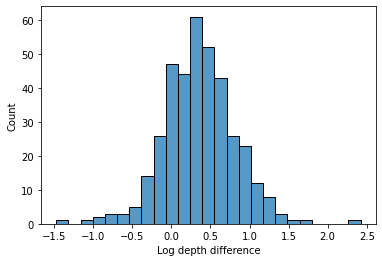

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(np.log(depths2) - np.log(depths1))
plt.xlabel('Log depth difference')

In [19]:
(np.log(depths2) - np.log(depths1)).mean()

0.3556432777717063

In [20]:
md

,cc_bool,cc_ids,batch_ids
sample id,,,
s0,0,0,0
s1,1,0,0
s2,0,1,0
s3,1,1,0
s4,0,2,0
...,...,...,...
s749,1,374,7
s750,0,375,7
s751,1,375,7


# Create household matched simulations

In [21]:
david_md = pd.read_table('../sfari/data/sra/David2021/sample_metadata_JM-v2.txt', index_col=0)
david_md = david_md[['Treatment', 'Pair', 'age_month_ok', 'Gender']]
david_md['Age'] = david_md['age_month_ok'] / 12
david_md['Sex'] = david_md['Gender'].apply(lambda x: {'m': 'male', 'f': 'female'}[x.lower()])
david_md['Status'] = david_md['Treatment'].apply(lambda x: {'Aut': 'ASD', 'Control': 'Control'}[x])

sex_ratio = pd.pivot(david_md[['Status', 'Sex']].value_counts().reset_index(), 
                     index='Status', columns='Sex')
sex_ratio = sex_ratio / sex_ratio.sum(axis=1).values.reshape(-1, 1)
sex_ratio

0          
Sex        female      male
Status                     
ASD      0.279412  0.720588
Control  0.470588  0.529412

In [22]:
mu, std = np.log(david_md['Age']).mean(), np.log(david_md['Age']).std()

age_diffs = david_md[['Age', 'Pair']].groupby('Pair').diff().dropna()
age_diffs.mean().values, age_diffs.std().values

(array([-0.20895522]), array([2.06039764]))

In [23]:
(age_diffs<0).sum().values, np.sum(age_diffs == 0).values, (age_diffs>0).sum().values

(array([32]), array([10]), array([25]))

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>)

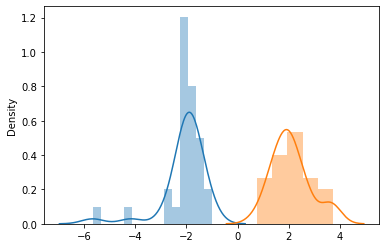

In [24]:
sns.distplot(age_diffs.values[age_diffs.values<0]), sns.distplot(age_diffs.values[age_diffs.values>0])

In [25]:
age_diffs.values[age_diffs.values<0].mean(), age_diffs.values[age_diffs.values<0].std() 

(-2.0703125, 0.8511403132852453)

In [26]:
age_diffs.values[age_diffs.values>0].mean(), age_diffs.values[age_diffs.values>0].std() 

(2.09, 0.7367043730923097)

Simulating age-sex matching and sibling matching

1. Generate age, sex and households from data
2. From generated covariates, generate age-sex matching and household matching.

In [36]:
from scipy.special import expit as sigmoid
from skbio.stats.composition import clr_inv as softmax


def age_diff_f(x, age_diff_loc, age_diff_scale, state):
    """ Generate age differences """
    age, pos = x
    if pos == 0:
        diff = state.normal(age_diff_loc[0], age_diff_scale[0])
    elif pos == 2:
        diff = state.normal(age_diff_loc[1], age_diff_scale[1])
    else:
        diff = 0
    return age + diff

def sex_gen(x, aut_sex, control_sex, state):
    aut_sex = np.array(aut_sex) / sum(aut_sex)
    control_sex = np.array(control_sex) / sum(control_sex)
    if x == 0:
        return state.choice([0, 1], p=aut_sex)
    else:
        return state.choice([0, 1], p=control_sex)

def interleave(x, y):
    z = np.empty((x.size + y.size,), dtype=y.dtype)
    z[0::2] = x
    z[1::2] = y
    return z

def _household_negative_binomial_sim(n=100, b=2, d=10, depth=50,
                                     aut_sex = [0.1, 0.3],
                                     control_sex = [0.5, 0.5],
                                     age_loc = 1.43,
                                     age_scale = 0.45,
                                     age_diff_p = [0.3, 0.1, 0.2],
                                     age_diff_loc = [-2, 2],
                                     age_diff_scale = [0.85, 0.73],
                                     age_traj_loc = [0, 0],
                                     age_traj_scale = [1, 1],
                                     disp_scale = 0.1,
                                     batch_scale = 0.1,
                                     diff_scale = 1,
                                     control_loc = None,
                                     control_scale = 0.1,
                                     state=None, params=dict()):
    """ Simulate case-controls from Negative Binomial distribution

    Parameters
    ----------
    sex_ratio : pd.DataFrame
       Table of sex ratios for ASD vs Control subjects.
    n : int
       Number of samples (must be divisible by 2).
    b : int
       Number of batches (must be able to divide n).
    d : int
       Number of microbes
    depth : int
       Sequencing depth
    aut_sex : np.array
       ASD sex ratio
    control_sex : np.array
       Control sex ratio
    age_loc : float
       Mean of age distribution
    age_scale : float
       Std dev of age distribution
    age_diff_p : np.array
       Probability of being less than negative, 0 or positive
    age_diff_loc : np.array
       Mean of age difference distributions (for both negative and positive age diffs)
    age_diff_scale : np.array
       Std dev of age difference distributions (for both negative and positive age diffs)
    age_diff_loc : np.array
       Mean of Age trajectory intercept and slope distributions
    age_diff_scale : np.array
       Std dev of Age trajectory intercept and slope distributions
    batch_scale : float
       Std dev of batch distribution
    control_loc : float
       Mean of control distribution (also the houseshold intercept)
    control_scale : float
       Std dev of control distribution (also the houseshold intercept)
    state : np.random.RandomState or int or None
       Random number generator.
    params : dict
       Dictionary of parameters to initialize simulations

    Returns
    -------
    table : pd.DataFrame
        Simulated counts
    md : pd.DataFrame
        Simulated metadata
    diff : pd.DataFrame
        Ground truth differentials
    """
    if state is None:
        state = np.random.RandomState(0)
    elif isinstance(state, int):
        state = np.random.RandomState(state)

    # dimensionality
    c = n // 2
    # setup scaling parameters
    if control_loc is None:
        control_loc = np.log(1 / d)
    eps = 0.1      # random effects for intercepts
    delta = 0.1    # size of overdispersion
    # setup priors
    a1 = state.normal(eps, eps, size=d)
    diff = params.get('diff', state.normal(0, diff_scale, size=d))
    disp = params.get('disp', state.lognormal(np.log(delta), disp_scale, size=(2, d)))
    
    batch_mu = params.get('batch_mu', state.normal(0, 1, size=(b, d)))
    batch_disp = params.get('batch_disp', state.lognormal(np.log(delta), batch_scale, size=(b, d)))
    control_mu = params.get('control_mu', state.normal(control_loc, 1, size=(d)))
    control_sigma = params.get('control_sigma', state.lognormal(np.log(delta), control_scale, size=(d)))
    control = np.vstack([state.normal(control_mu, control_sigma) for _ in range(c)])
    
    depth = np.log(state.poisson(depth, size=n))
    depth_diff = state.exponential(0.3, size=n)
    # depth = np.array([np.log(depth)] * n)  # for debugging
    # look up tables
    bs = n // b  # batch size
    batch_ids = np.repeat(np.arange(b), bs)
    batch_ids = np.hstack((
        batch_ids,
        np.array([b - 1] * (n - len(batch_ids)))
    )).astype(np.int64)
    cc_bool = np.arange(n) % 2  # case or control
    cc_ids = np.repeat(np.arange(c), 2)
    
    # setup age and sex distributions
    age_diff_p = np.array(age_diff_p) / sum(age_diff_p)
    age_pos = state.choice([0, 1, 2], p=age_diff_p, size=n)
    age_init = state.lognormal(age_loc, age_scale, size= n // 2)
    age_params = list(zip(list(age_init), list(age_pos)))
    age_pair = np.array(list(map(
        lambda x: age_diff_f(x, age_diff_loc, age_diff_scale, state), age_params)))
    age = interleave(age_init, age_pair)
    age[age < 1] = 1  # no negative ages
    age = np.round(age, 1)
    sex = np.array(list(map(lambda x: sex_gen(x, aut_sex, control_sex, state), cc_bool)))
    age_traj_int = state.normal(age_traj_loc[0], age_traj_scale[0], size=d)
    age_traj_coef = state.normal(age_traj_loc[1], age_traj_scale[1], size=d)
    y = np.zeros((n, d))
    # model simulation
    for s in range(n):
        lam = np.zeros(d)
        for i in range(d):
            # control counts
            lam[i] = batch_mu[batch_ids[s], i] + control[cc_ids[s], i]
            # case counts (if applicable)
            if cc_bool[s] == 1:
                lam[i] += diff[i]
            # add in age confounder (modeled as lam += a x + b, where x=age)
            # make age effects saturate around 5 years old
            lam[i] += age_traj_coef[i] * age[s] + age_traj_int[i]
            #lam = np.log(sigmoid(lam))   # convert to log proportions
        
        # normalize proportions to 1
        lam = np.log(softmax(lam)) 
        #lam = lam - np.log(np.exp(lam).sum())
        
        for i in range(d):
            if cc_bool[s] == 1:
                lam[i] += depth_diff[s]
            lam[i] += depth[s] 
            
            alpha = (np.exp(a1[i]) / np.exp(lam[i]))
            alpha += disp[cc_bool[s], i]
            alpha += batch_disp[batch_ids[s], i]
            # phi = (1 / alpha)  # stan's parameterization
            nb = negative_binomial_rvs(np.exp(lam[i]), alpha, state)
            y[s, i] = nb
    oids = [f'o{x}' for x in range(d)]
    sids = [f's{x}' for x in range(n)]
    table = pd.DataFrame(y, index=sids, columns=oids)
    md = pd.DataFrame({'cc_bool': cc_bool.astype(np.str),
                       'cc_ids': cc_ids.astype(np.str),
                       'age' : age,
                       'sex' : sex,
                       'batch_ids': batch_ids.astype(np.str)},
                      index=sids)
    md.index.name = 'sample id'
    return table, md, diff, age_traj_int, age_traj_coef

In [37]:
n = 1500
b = 8
d = 878
state = np.random.RandomState(0)
table, md, new_diff, age_traj_int, age_traj_coef = _household_negative_binomial_sim(
    n, b, d, depth=5000, state=state,
    params=dict(
        diff=diff.values,
        disp=disp.values.T,
        batch_mu=batch_mu.values.T,
        batch_disp=np.clip(batch_disp.values / 10, a_min=0., a_max=1.).T,
        control_mu=control_mu.values.ravel(),
        control_sigma=control_sigma.values.ravel()
    )
)

<ipython-input-36-1e848dc90013>:178: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  md = pd.DataFrame({'cc_bool': cc_bool.astype(np.str),
<ipython-input-36-1e848dc90013>:179: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'cc_ids': cc_ids.astype(np.str),
<ipython-input-36-1e848dc90013>:182: DeprecationWarning: `np.str` is a deprecated alias for the builtin `

Save age-sex matched and household metadata

In [46]:
from q2_matchmaker._matching import _matchmaker
age_match_ids = _matchmaker(md, 'cc_bool', ['age', 'sex', 'batch_ids'], 
                            [False, True, True]).astype(np.int64)
md['age_sex_match_ids'] = age_match_ids

# only keep age-sex match ids that have age pairings within 1 year
filt_samps = md[['age', 'age_sex_match_ids']].groupby('age_sex_match_ids').diff().dropna()
filt_samps = set(filt_samps.loc[np.abs(filt_samps['age']) >= 0.5].index)
submd = md.loc[[x not in filt_samps for x in md.index]]
submd = submd.groupby('age_sex_match_ids').filter(lambda x: len(x) == 2)
submd.to_csv('../sfari/data/sra/Combined/simulated5_agesex_metadata.txt', sep='\t')

# stratify the household matching
pairs = set(state.choice(md['cc_ids'].unique(), submd.shape[0] // 2, replace=False))
idx = md.apply(lambda x: x['cc_ids'] in pairs, axis=1)
submd2 = md.loc[idx]
submd2.to_csv('../sfari/data/sra/Combined/simulated5_houseshold_metadata.txt', sep='\t')

# stratify the age sex matching
pairs = set(state.choice(md['age_sex_match_ids'].unique(), submd.shape[0] // 2, replace=False))
submd3 = md.apply(lambda x: x['age_sex_match_ids'] in pairs, axis=1)
submd3 = md.loc[idx]
submd3.to_csv('../sfari/data/sra/Combined/simulated5_agesex_relaxed_metadata.txt', sep='\t')

with biom_open('../sfari/data/sra/Combined/simulated5.biom', 'w') as f:
    t = biom.Table(table.values.T, 
                   posterior['posterior']['features'], 
                   table.index)
    t.to_hdf5(f, 'simulated household')

In [39]:
pd.Series(table.values.ravel()).describe()

count    1.317000e+06
mean     6.997267e+00
std      1.856652e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.601700e+04
dtype: float64

In [40]:
np.mean((table > 0).values)

0.05555353075170843

In [41]:
table.sum(axis=1).describe()

count     1500.000000
mean      6143.600667
std       3775.831437
min       1037.000000
25%       4226.250000
50%       5347.000000
75%       6988.250000
max      70162.000000
dtype: float64

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


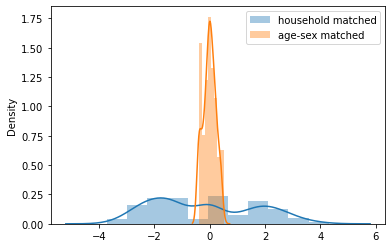

In [42]:
sns.distplot(md[['age', 'cc_ids']].groupby('cc_ids').diff().dropna(), label='household matched')
sns.distplot(submd[['age', 'age_sex_match_ids']].groupby('age_sex_match_ids').diff().dropna(), 
             label='age-sex matched')
plt.legend()